In [3]:
%matplotlib
import tclab  # pip install tclab
from time import sleep

Using matplotlib backend: Qt5Agg


In [4]:
# Connect to Arduino
a = tclab.TCLab()

TCLab version 0.4.6
Arduino Leonardo connected on port COM8 at 115200 baud.
TCLab Firmware Version 1.01.


### Blink LED on and off

In [5]:
numberOfBlinks = 10
for i in range(numberOfBlinks):
    print('LED On')
    a.LED(100)
    sleep(0.5)
    a.LED(0)
    sleep(0.5)
    print('LED off')

LED On
LED off
LED On
LED off
LED On
LED off
LED On
LED off
LED On
LED off
LED On
LED off
LED On
LED off
LED On
LED off
LED On
LED off
LED On
LED off


### Import other tools and helper functions

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import time

# save txt file
def save_txt(t,u1,u2,y1,y2,sp1,sp2):
    data = np.vstack((t,u1,u2,y1,y2,sp1,sp2))  # vertical stack
    data = data.T                 # transpose data
    top = 'Time (sec), Heater 1 (%), Heater 2 (%), ' \
        + 'Temperature 1 (degC), Temperature 2 (degC), ' \
        + 'Set Point 1 (degC), Set Point 2 (degC)' 
    np.savetxt('data.txt',data,delimiter=',',header=top,comments='')

## Try the sensors to get an ambient temperature

In [7]:
Ta_degC = min(a.T1,a.T2)  
Ta_degC
# Run time in minutes
run_time = 10.0

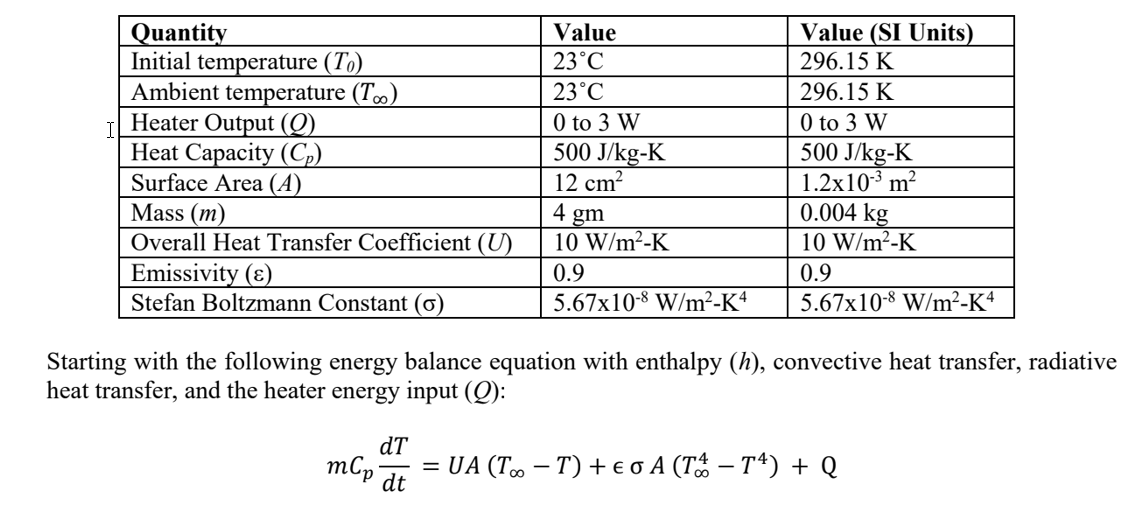
# Energy balance model

In [8]:
def heat(x,t,Q):
    # Parameters
    Ta = Ta_degC + 273.15   # K
    U = 10.0           # W/m^2-K
    m = 4.0/1000.0     # kg
    Cp = 0.5 * 1000.0  # J/kg-K    
    A = 12.0 / 100.0**2 # Area in m^2
    alpha = 0.01       # W / % heater
    eps = 0.9          # Emissivity
    sigma = 5.67e-8    # Stefan-Boltzman

    # Temperature State 
    T = x[0]

    # Nonlinear Energy Balance
    dTdt = (1.0/(m*Cp))*(U*A*(Ta-T) \
            + eps * sigma * A * (Ta**4 - T**4) \
            + alpha*Q)
    return dTdt

# First Order Plus Dead Time (FOPDT)

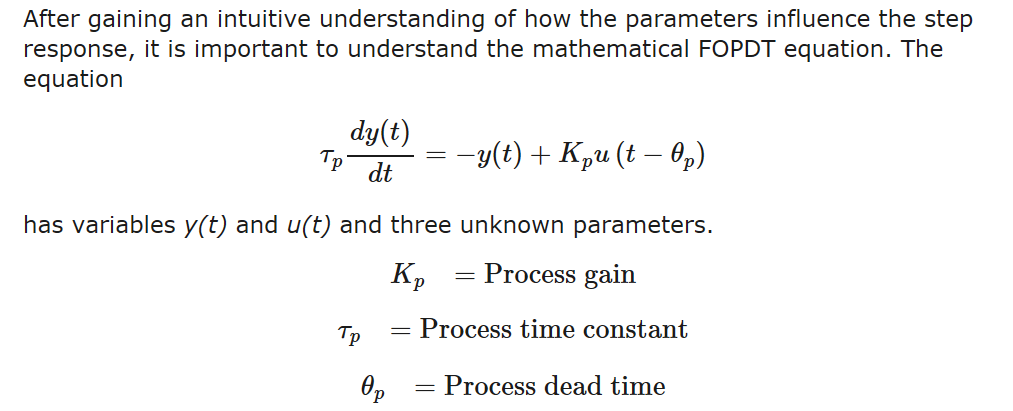

#### Setting up variables

In [9]:
# FOPDT model
Kp = 0.5      # degC/%
tauP = 120.0  # seconds
thetaP = 10   # seconds (integer)
Tss = Ta_degC      # degC (ambient temperature)
Qss = 0       # % heater



# Number of cycles
loops = int(60.0*run_time)
tm = np.zeros(loops)

# Temperature intialization
Tsp1 = np.ones(loops) * 23.0 # set point (degC)
T1 = np.ones(loops) * a.T1 # measured T (degC)

Tsp2 = np.ones(loops) * 23.0 # set point (degC)
T2 = np.ones(loops) * a.T2 # measured T (degC)

In [10]:
# Predictions
Tp = np.ones(loops) * a.T1
error_eb = np.zeros(loops)
Tpl = np.ones(loops) * a.T1
error_fopdt = np.zeros(loops)

In [11]:
# Predictions
Tp = np.ones(loops) * a.T1
error_eb = np.zeros(loops)
Tpl = np.ones(loops) * a.T1
error_fopdt = np.zeros(loops)

In [12]:
# impulse tests (0 - 100%)
Q1 = np.ones(loops) * 0.0
Q2 = np.ones(loops) * 0.0
Q1[10:110] = 50.0 # step up for 100 sec
Q1[200:300] = 90.0 # step up for 100 sec
Q1[400:500] = 70.0 # step up for 100 sec

print('Running Main Loop. Ctrl-C to end.')
print('  Time   Q1     Q2    T1     T2')
print('{:6.1f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}'.format(tm[0], \
                                                       Q1[0], \
                                                       Q2[0], \
                                                       T1[0], \
                                                       T2[0]))

Running Main Loop. Ctrl-C to end.
  Time   Q1     Q2    T1     T2
   0.0   0.00   0.00  18.32  18.00


In [13]:
# Create plot
plt.figure(figsize=(10,7))
plt.ion()
plt.show()

In [14]:
# Main Loop
start_time = time.time()
prev_time = start_time
try:
    for i in range(1,loops):
        # Sleep time
        sleep_max = 1.0
        sleep = sleep_max - (time.time() - prev_time)
        if sleep>=0.01:
            time.sleep(sleep-0.01)
        else:
            time.sleep(0.01)

        # Record time and change in time
        t = time.time()
        dt = t - prev_time
        prev_time = t
        tm[i] = t - start_time

        # Read temperatures in Kelvin 
        T1[i] = a.T1
        T2[i] = a.T2

        # Simulate one time step with Energy Balance
        Tnext = odeint(heat,Tp[i-1]+273.15,[0,dt],args=(Q1[i-1],))
        Tp[i] = Tnext[1]-273.15
        error_eb[i] = error_eb[i-1] + abs(Tp[i]-T1[i])

        # Simulate one time step with FOPDT model
        z = np.exp(-dt/tauP)
        Tpl[i] = (Tpl[i-1]-Tss) * z \
                 + (Q1[max(0,i-int(thetaP)-1)]-Qss)*(1-z)*Kp \
                 + Tss
        error_fopdt[i] = error_fopdt[i-1] + abs(Tpl[i]-T1[i])

        # Write output (0-100)
        a.Q1(Q1[i])
        a.Q2(Q2[i])

        # Print line of data
        print('{:6.1f} {:6.2f} {:6.2f} {:6.2f} {:6.2f}'.format(tm[i], \
                                                               Q1[i], \
                                                               Q2[i], \
                                                               T1[i], \
                                                               T2[i]))

        # Plot
        plt.clf()
        ax=plt.subplot(3,1,1)
        ax.grid()
        plt.plot(tm[0:i],T1[0:i],'ro',label=r'$T_1$ measured')
        plt.plot(tm[0:i],Tp[0:i],'k-',label=r'$T_1$ energy balance')
        plt.plot(tm[0:i],Tpl[0:i],'g:',label=r'$T_1$ FOPDT')
        plt.plot(tm[0:i],T2[0:i],'bx',label=r'$T_2$ measured')
        plt.ylabel('Temperature (deg C)')
        plt.legend(loc='best')
        ax=plt.subplot(3,1,2)
        ax.grid()
        plt.plot(tm[0:i],error_eb[0:i],'k-',label='Energy Balance')
        plt.plot(tm[0:i],error_fopdt[0:i],'g:',label='Linear')
        plt.ylabel('Cumulative Error')
        plt.legend(loc='best')
        ax=plt.subplot(3,1,3)
        ax.grid()
        plt.plot(tm[0:i],Q1[0:i],'r-',label=r'$Q_1$')
        plt.plot(tm[0:i],Q2[0:i],'b:',label=r'$Q_2$')
        plt.ylabel('Heaters')
        plt.xlabel('Time (sec)')
        plt.legend(loc='best')
        plt.draw()
        plt.pause(0.05)

    # Turn off heaters
    a.Q1(0)
    a.Q2(0)
    # Save text file
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    # Save figure
    plt.savefig('test_Models.png')

# Allow user to end loop with Ctrl-C           
except KeyboardInterrupt:
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Shutting down')
    a.close()
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    plt.savefig('test_Models.png')

# Make sure serial connection still closes when there's an error
except:           
    # Disconnect from Arduino
    a.Q1(0)
    a.Q2(0)
    print('Error: Shutting down')
    a.close()
    save_txt(tm[0:i],Q1[0:i],Q2[0:i],T1[0:i],T2[0:i],Tsp1[0:i],Tsp2[0:i])
    plt.savefig('test_Models.png')
    raise

   1.0   0.00   0.00  18.32  18.00
   2.0   0.00   0.00  18.32  18.00
   3.0   0.00   0.00  18.32  18.00
   4.0   0.00   0.00  18.35  18.00
   5.0   0.00   0.00  18.32  18.00
   5.9   0.00   0.00  18.32  18.00
   6.9   0.00   0.00  18.32  18.00
   7.9   0.00   0.00  18.35  18.00
   8.9   0.00   0.00  18.32  18.00
   9.9  50.00   0.00  18.38  18.00
  10.9  50.00   0.00  18.45  18.03
  11.9  50.00   0.00  18.51  18.00
  12.9  50.00   0.00  18.58  18.00
  13.9  50.00   0.00  18.51  18.00
  14.9  50.00   0.00  18.64  18.00
  15.9  50.00   0.00  18.64  18.00
  16.8  50.00   0.00  18.64  18.00
  17.8  50.00   0.00  18.67  18.00
  18.8  50.00   0.00  18.74  18.03
  19.8  50.00   0.00  18.96  18.00
  20.8  50.00   0.00  18.96  18.00
  21.8  50.00   0.00  18.96  18.06
  22.8  50.00   0.00  19.09  18.03
  23.8  50.00   0.00  19.29  18.03
  24.8  50.00   0.00  19.29  18.06
  25.8  50.00   0.00  19.58  18.13
  26.8  50.00   0.00  19.61  18.22
  27.8  50.00   0.00  19.77  18.22
  28.7  50.00   0.00

 233.9  90.00   0.00  37.33  23.35
 234.9  90.00   0.00  37.66  23.38
 235.9  90.00   0.00  37.98  23.41
 236.9  90.00   0.00  38.27  23.48
 237.9  90.00   0.00  38.46  23.48
 238.8  90.00   0.00  38.82  23.48
 239.8  90.00   0.00  39.11  23.48
 240.8  90.00   0.00  39.36  23.48
 241.8  90.00   0.00  39.82  23.51
 242.8  90.00   0.00  40.01  23.57
 243.8  90.00   0.00  40.36  23.73
 244.8  90.00   0.00  40.62  23.77
 245.8  90.00   0.00  41.01  23.80
 246.8  90.00   0.00  41.27  23.80
 247.8  90.00   0.00  41.56  23.80
 248.8  90.00   0.00  41.85  23.80
 249.8  90.00   0.00  42.17  23.83
 250.7  90.00   0.00  42.49  23.96
 251.7  90.00   0.00  42.81  24.09
 252.7  90.00   0.00  43.13  24.09
 253.7  90.00   0.00  43.46  24.12
 254.7  90.00   0.00  43.78  24.12
 255.7  90.00   0.00  44.10  24.12
 256.7  90.00   0.00  44.42  24.19
 257.7  90.00   0.00  44.75  24.15
 258.7  90.00   0.00  45.07  24.38
 259.7  90.00   0.00  45.36  24.44
 260.7  90.00   0.00  45.68  24.44
 261.6  90.00   0.00

 466.8  70.00   0.00  51.84  29.60
 467.8  70.00   0.00  51.84  29.60
 468.8  70.00   0.00  52.03  29.60
 469.8  70.00   0.00  52.16  29.60
 470.8  70.00   0.00  52.42  29.60
 471.7  70.00   0.00  52.51  29.73
 472.7  70.00   0.00  52.74  29.79
 473.7  70.00   0.00  52.80  29.83
 474.7  70.00   0.00  53.09  29.89
 475.7  70.00   0.00  53.13  29.92
 476.7  70.00   0.00  53.42  29.92
 477.7  70.00   0.00  53.45  29.89
 478.7  70.00   0.00  53.77  29.92
 479.7  70.00   0.00  53.80  29.92
 480.7  70.00   0.00  54.09  29.92
 481.7  70.00   0.00  54.09  29.92
 482.6  70.00   0.00  54.41  29.92
 483.6  70.00   0.00  54.45  29.99
 484.6  70.00   0.00  54.74  30.05
 485.6  70.00   0.00  54.74  30.12
 486.6  70.00   0.00  54.99  30.21
 487.6  70.00   0.00  55.06  30.24
 488.6  70.00   0.00  55.28  30.24
 489.6  70.00   0.00  55.38  30.24
 490.6  70.00   0.00  55.51  30.24
 491.6  70.00   0.00  55.70  30.24
 492.6  70.00   0.00  55.74  30.28
 493.5  70.00   0.00  56.03  30.34
 494.5  70.00   0.00